In [148]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random

from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [149]:
# create a dict
activity_label = {
    0: "WALKING",
    1: "WALKING_UPSTAIRS",
    2: "WALKING_DOWNSTAIRS",
    3: "SITTING",
    4: "STANDING",
    5: "LAYING"
}

In [150]:
X_train_signals_path = ('/home/clarkr/HAR/train/train_signals')
y_train_signals_path = ('/home/clarkr/HAR/train/y_train.txt')

X_test_signals_path = ('/home/clarkr/HAR/train/train_signals')
y_test_signals_path = ('/home/clarkr/HAR/train/y_train.txt')

In [151]:
def load_X(path):
    X = []
    os.chdir(path)
    for filename in os.listdir(path):
        if filename.endswith('.txt') and filename.startswith('total'):
            file = open(path+'/'+filename, 'r')
            X.append(            
                [np.array(serie, dtype=np.float32) for serie in [
                    row.replace('  ', ' ').strip().split(' ') for row in file
                ]]
            )
            file.close()
    return np.transpose(np.array(X), (1, 2, 0))
X_train = load_X(X_train_signals_path)
X_test = load_X(X_test_signals_path)

In [152]:
def load_y(path):
    file = open(path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()
        
    return y_ - 1
y_train = load_y(y_train_signals_path)
y_test = load_y(y_test_signals_path)

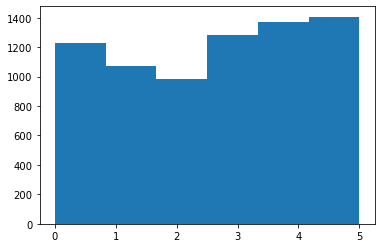

In [153]:
plt.hist(y_train, bins=6)
plt.show()

In [154]:
X_train.shape

(7352, 128, 3)

WALKING_UPSTAIRS
308


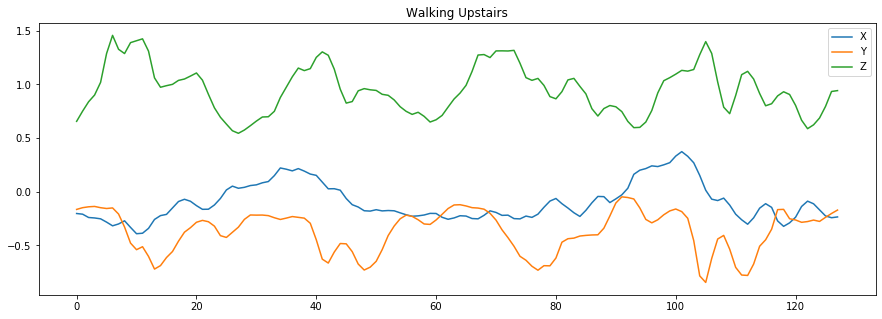

In [155]:
randi = 308
print(activity_label[int(y_train[randi])])
plt.figure(figsize = (15,5))
plt.plot(X_train[randi,:,0], label = 'X')
plt.plot(X_train[randi,:,1], label = 'Y')
plt.plot(X_train[randi,:,2], label = 'Z')
plt.title('Walking Upstairs')
plt.legend()
print(randi)

In [156]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(X_train.shape, y_train.shape)

(7352, 128, 3) (7352, 6)


In [157]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5)
print(X_val.shape)
print(X_test.shape)
print(y_val.shape)
print(y_test.shape)

(3676, 128, 3)
(3676, 128, 3)
(3676, 6)
(3676, 6)


In [158]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

X_train.shape

(7352, 128, 3)

In [159]:
model = Sequential()
model.add((Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features))))
model.add((Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add((Conv1D(filters=128, kernel_size=3, activation='relu')))
model.add((Conv1D(filters=128, kernel_size=3, activation='relu')))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add((Conv1D(filters=256, kernel_size=3, activation='relu')))
model.add((Conv1D(filters=256, kernel_size=3, activation='relu')))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_24 (Conv1D)           (None, 126, 64)           640       
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 124, 64)           12352     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 62, 64)            0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 62, 64)            256       
_________________________________________________________________
dropout_12 (Dropout)         (None, 62, 64)            0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 60, 128)           24704     
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 58, 128)          

In [160]:
verbose, epochs, batch_size = 1, 50, 64
learning_rate = 0.001
#decay_rate = learning_rate/epochs
opt = Adam(learning_rate = learning_rate)
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy'])

In [161]:
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=0)

Text(0, 0.5, 'Accuracy')

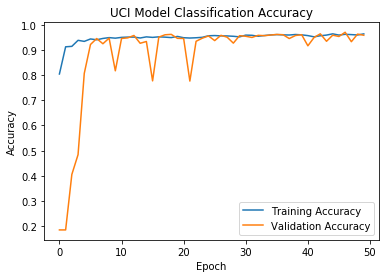

In [162]:
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()
plt.title('UCI Model Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

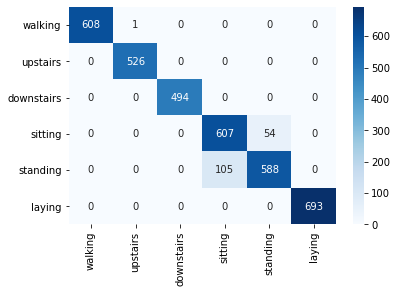

In [163]:
y_pred = model.predict(X_test)
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
axis = ['walking', 'upstairs', 'downstairs', 'sitting', 'standing', 'laying']
sns.heatmap(matrix, xticklabels = axis, yticklabels = axis, annot=True, cmap='Blues', fmt = 'g')



In [58]:
#(3605, 6684)